# Poisson Distribution

In [1]:
import math
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Local data location
path = fr"C:\Users\kazir\Desktop\Projects\nerdy_pick\db\nfl_data\nfl_off_stat.csv"
off_data = pd.read_csv(path, index_col=False)

In [3]:
player_name = "Jameis Winston"
player_data = off_data[off_data["Name"] == player_name]

In [4]:
stat_type = "Passing TD"
pass_td_line = 1.5
under_bet = math.floor(pass_td_line)
over_bet = math.ceil(pass_td_line)
odd = 100 / (100 + 182)
print(f"The implied probability of {player_name} over {pass_td_line}: {odd.__round__(2)}")
print(f"Probability of under {under_bet} {stat_type}: ?")
print(f"Probability of over {over_bet} {stat_type}: ?")

The implied probability of Jameis Winston over 1.5: 0.35
Probability of under 1 Passing TD: ?
Probability of over 2 Passing TD: ?


In [5]:
# Filter games with more than 10 pass attempts
player_data = player_data[player_data["Passes Completed"] >= 10]

In [6]:
data_by_team = player_data.groupby("Tm")[["Pass Attempts", "Passes Completed", "Passing Yds", "Passing TD"]].agg(
    [
        "count",
        "mean",
        "median",
        "std"
    ]
).T
data_by_team

Tm                              CLE         NOR         TAM
Pass Attempts    count     3.000000   11.000000   70.000000
                 mean     44.333333   27.909091   36.071429
                 median   46.000000   25.000000   35.000000
                 std       2.886751    8.537617    8.983594
Passes Completed count     3.000000   11.000000   70.000000
                 mean     27.666667   16.818182   22.157143
                 median   27.000000   15.000000   21.000000
                 std       2.081666    5.455606    5.805134
Passing Yds      count     3.000000   11.000000   70.000000
                 mean    321.333333  199.545455  280.128571
                 median  334.000000  222.000000  276.500000
                 std      80.748581   82.800198   73.527264
Passing TD       count     3.000000   11.000000   70.000000
                 mean      2.000000    1.727273    1.728571
                 median    2.000000    1.000000    2.000000
                 std       1.000000    1.555050    1.178570

In [7]:
passing_td_data = player_data[stat_type]
sample_size = len(passing_td_data)
td_mean = passing_td_data.mean()
td_mean_now = data_by_team["CLE"]["Passing TD"]["mean"]
td_std = passing_td_data.std()

print(f"Sample Mean {stat_type}: {td_mean:.2f}")
print(f"TAM Mean {stat_type}: {td_mean_now:.2f}")

Sample Mean Passing TD: 1.74
TAM Mean Passing TD: 2.00


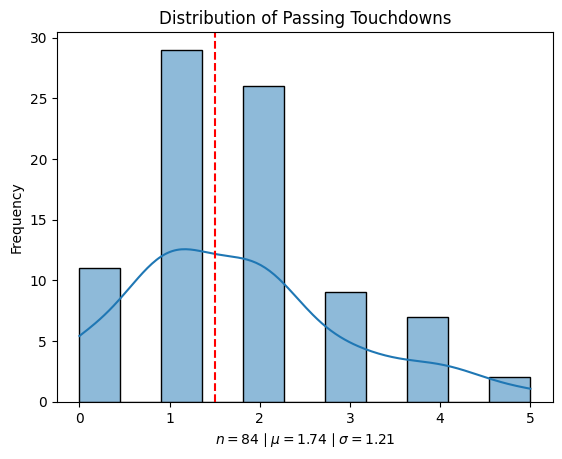

In [8]:
# Plot the distribution
sns.histplot(data=player_data, x=stat_type, kde=True)
plt.title("Distribution of Passing Touchdowns")
plt.axvline(x=pass_td_line, c="r", linestyle="--")
plt.xlabel(r"$n={" + f"{sample_size}" + r"} \mid \mu={" + f"{td_mean:.2f}" + r"} \mid \sigma={" + f"{td_std:.2f}" + r"}$")
plt.ylabel("Frequency")
plt.show()

In [9]:
sample_over_prob = sum(passing_td_data >= over_bet)/sample_size
print("Probability Using Sample Size")
print(f"Over or equal to {over_bet} {stat_type}: {round(sample_over_prob, 5)*100}%")
print(f"Under {over_bet} {stat_type}: {round(1-sample_over_prob, 5)*100}%")

Probability Using Sample Size
Over or equal to 2 Passing TD: 52.381%
Under 2 Passing TD: 47.619%


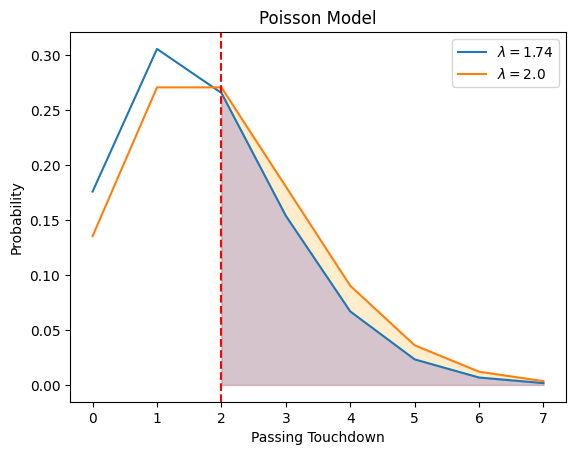

In [10]:
max_td = 7
k_values = range(max_td+1)
poisson_probs_sample_mean = [stats.poisson.pmf(mu=td_mean, k=k) for k in k_values]
poisson_probs_now_mean = [stats.poisson.pmf(mu=td_mean_now, k=k) for k in k_values]

# Plot the Poisson model
sns.lineplot(x=k_values, y=poisson_probs_sample_mean, label=f"$\lambda \equal {round(td_mean, 2)}$")
sns.lineplot(x=k_values, y=poisson_probs_now_mean, label=f"$\lambda \equal {round(td_mean_now, 2)}$")

# Fill under the curves
plt.fill_between(range(over_bet, max_td+1), poisson_probs_sample_mean[over_bet:], color='blue', alpha=0.2, label=f"Under $\lambda = {round(td_mean, 2)}$")
plt.fill_between(range(over_bet, max_td+1), poisson_probs_now_mean[over_bet:], color='orange', alpha=0.2, label=f"Under $\lambda = {round(td_mean_now, 2)}$")

plt.title("Poisson Model")
plt.xlabel("Passing Touchdown")
plt.ylabel("Probability")
plt.axvline(x=over_bet, c="r", linestyle="--")
plt.show()

In [11]:
# Probabilities on each k value (0, 1, 2...)
pd.DataFrame(
    index=range(max_td+1),
    data={
        round(td_mean, 2): poisson_probs_sample_mean,
        round(td_mean_now, 2): poisson_probs_now_mean
    }
)

,1.74,2.00
0,0.175855,0.135335
1,0.305653,0.270671
2,0.265627,0.270671
3,0.153895,0.180447
4,0.066871,0.090224
5,0.023246,0.036089
6,0.006734,0.012030
7,0.001672,0.003437


In [12]:
# CDF of P(2 <= X)
poisson_over_prob_sample_mean = 1-stats.poisson.cdf(mu=td_mean, k=under_bet)
poisson_over_prob_curr_mean = 1-stats.poisson.cdf(mu=td_mean_now, k=under_bet)

print(f"Bookmakers predict that {player_name} over {over_bet} {stat_type}: {odd.__round__(5)}")
print(f"The Poisson model predicts {player_name} over {over_bet} {stat_type} (λ = {td_mean.__round__(2)}): {poisson_over_prob_sample_mean.round(5)}")
print(f"The Poisson model predicts {player_name} over {over_bet} {stat_type} (λ = {td_mean_now}): {poisson_over_prob_curr_mean.round(5)}")

Bookmakers predict that Jameis Winston over 2 Passing TD: 0.35461
The Poisson model predicts Jameis Winston over 2 Passing TD (λ = 1.74): 0.51849
The Poisson model predicts Jameis Winston over 2 Passing TD (λ = 2.0): 0.59399


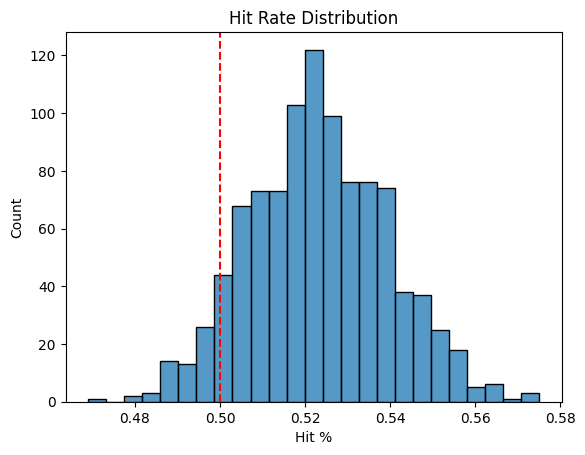

In [13]:
iter = 1000
sim_perct = np.zeros(iter)
idx = 0

while True:
    sim = np.zeros(iter)
    for i in range(iter):
        sim[i] = np.random.choice(player_data[stat_type], 1, replace=True)[0]
    sim_perct[idx] = sum(sim >= over_bet)/iter
    idx += 1
    if idx == iter:
        break

# Plot the results
sns.histplot(sim_perct)
plt.title("Hit Rate Distribution")
plt.axvline(x=0.50, c="r", linestyle="--")
plt.xlabel("Hit %")
plt.show()